<a href="https://colab.research.google.com/github/YangHyunu/SKT-FLY-AI-5/blob/main/4%EC%A3%BC%EC%B0%A8/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98/LeNet%2C_AlexNet%2C_VGG_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --user tqdm

### 필요한 라이브러리 호출

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt
from torch.utils.data import Dataset


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


모델 학습에 필요한 데이터셋의 전처리 <텐서변환 , 데이터증강>

In [ ]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase): # 클래스를 인스턴스화 해서 외부에서 함수처럼 호출 할 수 있도록 함
        return self.data_transform[phase](img) # phase: 변환 단계를 지정. 'train' 또는 'val' 값을 가질 수 있음.

In [ ]:
cat_directory = r'/content/drive/MyDrive/SKT_FLY_AI /4주차 파이토치/data/dogs-vs-cats/Cat' # 문자열 앞에 r을 쓰면 /를 escape 코드로 인식하지 않음
dog_directory = r'/content/drive/MyDrive/SKT_FLY_AI /4주차 파이토치/data/dogs-vs-cats/Dog'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)]) # sorted: 데이터<이미지>를 정렬된 리스트로 만들어서 반환
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
# os.path.join: 경로와 파일명을 결합하거나 분할된 경로를 하나로 합치고 싶을 때 사용
# os.listdir: 지정한 디렉터리 내 모든 파일의 리스트를 반환 ex) 예제에서 사용하는 Cat 디렉터리의 이미지 파일들을 모두 반환
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]  # opencv 가 지원하지 않는 파일 형식이거나 이미지가 어떤 것에 의하던 잘못된 이미지 일 때
# 이미지를 읽어 들일 때 자동으로 None 처리

random.seed(42)
random.shuffle(correct_images_filepaths)
print(len(correct_images_filepaths))
#train_images_filepaths = correct_images_filepaths[:20000] #성능을 향상시키고 싶다면 훈련 데이터셋을 늘려서 테스트해보세요
#val_images_filepaths = correct_images_filepaths[20000:-10] #훈련과 함께 검증도 늘려줘야 합니다
train_images_filepaths = correct_images_filepaths[:5000]
val_images_filepaths = correct_images_filepaths[5000:5100]   # 5000번에서 5099번까지의 이미지를 검증 데이터로
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

8009
5000 100 10


In [ ]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

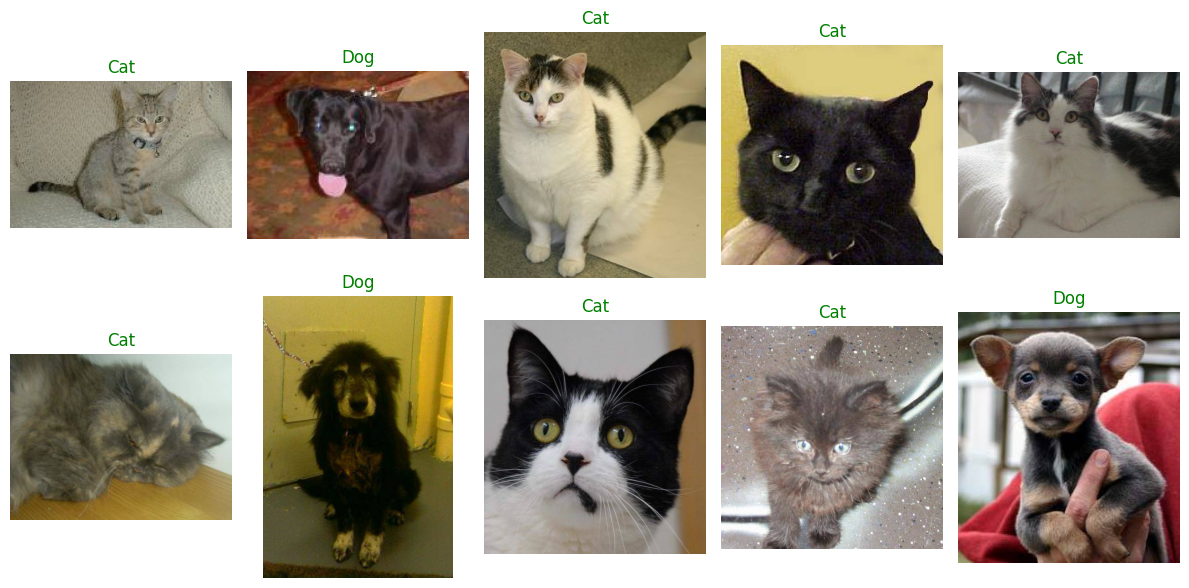

In [ ]:
display_image_grid(test_images_filepaths)

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        """
        초기화 메서드

        Parameters:
        file_list (list): 이미지 파일 경로의 리스트
        transform (callable, optional): 이미지 변환 함수. 기본값은 None
        phase (str): 데이터셋의 단계. 'train', 'val', 'test' 중 하나. 기본값은 'train'
        """
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        """
        데이터셋의 전체 길이를 반환하는 메서드

        Returns:
        int: 데이터셋의 전체 길이
        """
        return len(self.file_list)

    def __getitem__(self, idx): # 데이터셋에서 데이터 가져오는 부분, 결과는 텐서 형태로 반환됨
        """
        주어진 인덱스의 데이터를 반환하는 메서드

        Parameters:
        idx (int): 데이터의 인덱스

        Returns:
        tuple: (변환된 이미지, 레이블)
        """
        # 인덱스에 해당하는 이미지 파일 경로 가져오기
        img_path = self.file_list[idx]
        # 이미지 파일 열기
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        # 이미지 파일 이름에서 레이블 추출
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        # 변환된 이미지와 레이블 반환
        return img_transformed, label


In [ ]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

- 데이터셋 분리 및 전처리

In [ ]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


- 데이터 로더 : 배치관리 담당
- 한번에 모든 데이터를 불러오면 메모리에 부담을 줄 수 있기 때문에 필요할 떄 마다 <호출> 배치사이즈 만큼의 이미지를 가져옴

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) #shuffle : 메모리로 부터 데이터를 가져올 때 임의로 섞어서 가져올지 유무
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1])


- iter(): DataLoader 객체를 이터레이터(iterator)로 변환합니다. 이터레이터는 next() 함수를 사용하여 다음 배치를 가져올 수 있습니다.
- next(): 이터레이터에서 다음 배치를 가져옵니다. 여기서는 inputs와 labels를 반환합니다.
- inputs: 배치 단위의 입력 데이터 텐서
- labels: 배치 단위의 레이블 텐서


즉, iter()와 next()는 DataLoader가 호출될 때 마다 기능함
 for 문의 기능을 대신함
 만약 배치사이즈가 64면 데이터로더 객체가 데이터 셋에서 64개의 이미지를 가져온 후 이터레이터 객체로 변환 시켜 하나의 이미지씩 순차적으로 반환함

In [ ]:
import torch
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*53*53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)  # 이진 분류
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        out1 = self.cnn1(x)
        out2 = self.relu1(out1)
        out3 = self.maxpool1(out2)
        out4 = self.cnn2(out3)
        out5 = self.relu2(out4)
        out6 = self.maxpool2(out5)
        out7 = out6.view(out6.size(0), -1)  # 완전 연결층으로 이미지를 전달하기 위해 flatten
        out8 = self.fc1(out7)
        out9 = self.relu5(out8)
        out10 = self.fc2(out9)
        out = self.output(out10)
        return out


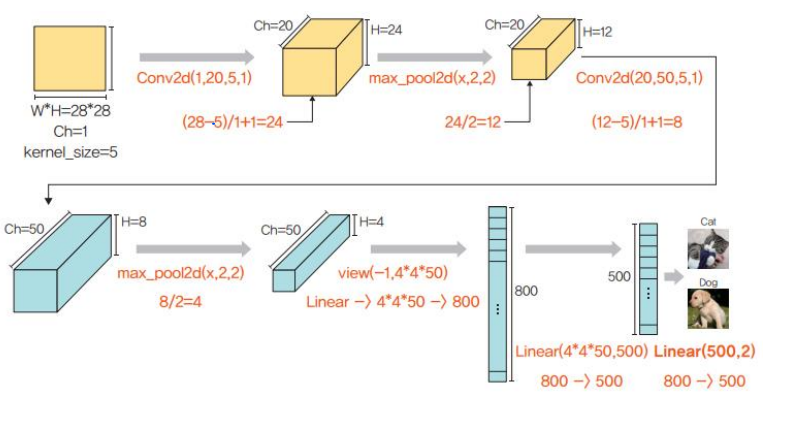

### 모델 객체 생성

In [ ]:
model = LeNet()
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [ ]:
from torchsummary import summary
summary(model.cuda(), input_size =(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
              ReLU-8                  [-1, 512]               0
            Linear-9                    [-1, 2]           1,026
          Softmax-10                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Es

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


## 모델 학습
  - 옵티마이저 , 손실함수 정의

In [ ]:
optimizer =optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
model= model.to(device)

In [ ]:
from logging import critical
criterion = criterion.to(device)

In [ ]:
import time
import torch
from tqdm import tqdm

def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0
    best_model_wts = model.state_dict()

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-' * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()  # 모델을 평가 모드로 설정

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()  # 역전파 단계를 실행하기 전에 기울기를 0으로 초기화

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)  # 손실 함수를 이용한 오차 계산

                    if phase == 'train':
                        loss.backward()  # 모델의 학습 가능한 모든 파라미터에 대해 기울기를 계산
                        optimizer.step()  # 파라미터 업데이트
                    # epoch_loss 에 모든 배치의  손실을 저장함

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            # len(dataloader_dict[phase].dataset)는 각 phase의 데이터셋 크기
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 최상의 모델 가중치를 로드합니다
    model.load_state_dict(best_model_wts)
    return model


- 손실과 정확도 누적: epoch_loss와 epoch_corrects는 학습 단계와 검증 단계 모두에서 각 배치의 손실과 정확한 예측 개수를 누적
- 평균 손실과 정확도 계산: 에포크가 끝날 때마다 epoch_loss와 epoch_acc를 계산하여 각 단계의 평균 손실과 정확도를 구함
- 출력: 각 단계의 손실과 정확도를 출력
- 최고 모델 저장: 검증 단계에서 최고의 정확도를 기록한 모델의 가중치를 저장

In [ ]:
import time

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


100%|██████████| 157/157 [00:42<00:00,  3.74it/s]


train Loss: 0.6795 Acc: 0.5648


100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


val Loss: 0.6564 Acc: 0.6400
Epoch 2/10
--------------------


100%|██████████| 157/157 [00:41<00:00,  3.81it/s]


train Loss: 0.6563 Acc: 0.6176


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


val Loss: 0.6492 Acc: 0.5800
Epoch 3/10
--------------------


100%|██████████| 157/157 [00:40<00:00,  3.84it/s]


train Loss: 0.6483 Acc: 0.6274


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


val Loss: 0.6285 Acc: 0.6800
Epoch 4/10
--------------------


100%|██████████| 157/157 [00:41<00:00,  3.81it/s]


train Loss: 0.6366 Acc: 0.6414


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


val Loss: 0.6230 Acc: 0.6500
Epoch 5/10
--------------------


100%|██████████| 157/157 [00:41<00:00,  3.79it/s]


train Loss: 0.6342 Acc: 0.6444


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


val Loss: 0.6058 Acc: 0.6500
Epoch 6/10
--------------------


100%|██████████| 157/157 [00:41<00:00,  3.81it/s]


train Loss: 0.6208 Acc: 0.6632


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


val Loss: 0.6322 Acc: 0.6100
Epoch 7/10
--------------------


100%|██████████| 157/157 [00:41<00:00,  3.82it/s]


train Loss: 0.6241 Acc: 0.6596


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


val Loss: 0.6332 Acc: 0.6700
Epoch 8/10
--------------------


100%|██████████| 157/157 [00:41<00:00,  3.80it/s]


train Loss: 0.6169 Acc: 0.6720


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


val Loss: 0.5933 Acc: 0.6900
Epoch 9/10
--------------------


100%|██████████| 157/157 [00:41<00:00,  3.82it/s]


train Loss: 0.6133 Acc: 0.6720


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


val Loss: 0.6029 Acc: 0.6700
Epoch 10/10
--------------------


100%|██████████| 157/157 [00:41<00:00,  3.80it/s]


train Loss: 0.6035 Acc: 0.6864


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

val Loss: 0.5870 Acc: 0.7000
Training complete in 7m 1s
Best val Acc: 0.700000


## 테스트

In [ ]:
def test(model, test_images_filepaths):
  id_list=[]
  pred_list=[]
  _id =0
  with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
      img = Image.open(test_path)
      _id = test_path.split('/')[-1].split('.')[1]
      transform = ImageTransform(size, mean, std)
      img = transform(img, phase ='val')
      img = img.unsqueeze(0)
      img = img.to(device)

      model.eval()
      outputs = model(img)
      preds_prob ,pred_ans = torch.max(outputs,1)
      id_list.append(_id)
      pred_list.append(pred_ans.cpu().item())
  return id_list, pred_list

In [ ]:
import pandas as pd
id_list, pred_list = test(model, test_images_filepaths)
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})
res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('/content/drive/MyDrive/SKT_FLY_AI /4주차 파이토치/LesNet.csv',index=False)

100%|██████████| 10/10 [00:00<00:00, 70.02it/s]


In [ ]:
res.head(10)

,id,label
0,1181,0
1,1753,0
2,1819,0
3,2026,0
4,2108,1
5,2643,0
6,2803,0
7,2824,0
8,2861,0
9,3023,0


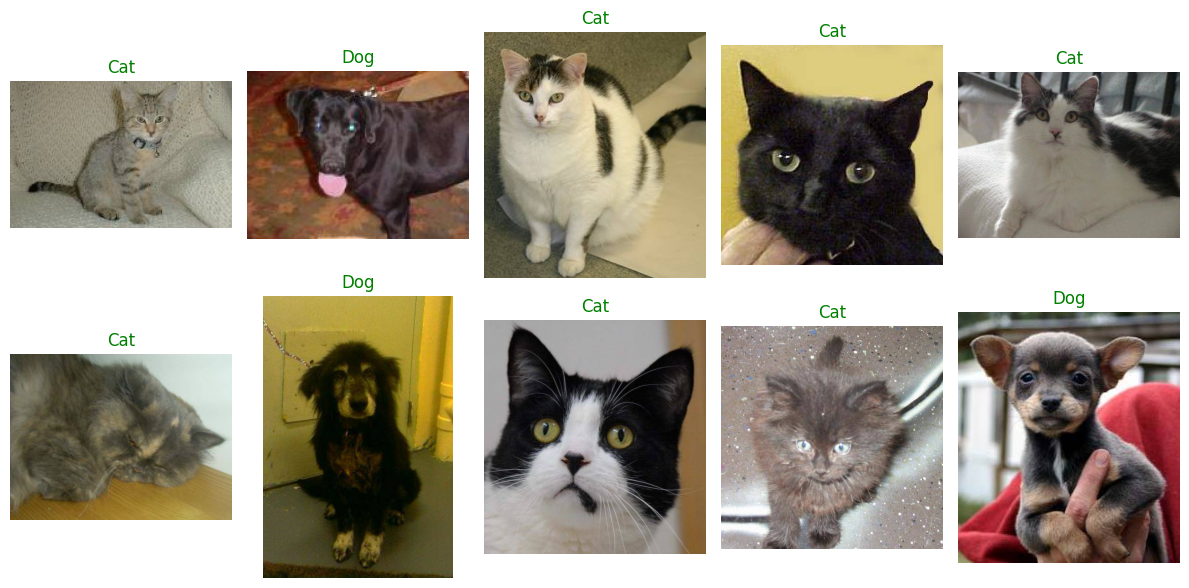

In [ ]:
display_image_grid(test_images_filepaths)

# Alex_Net

### 모델 네트워크 정의

In [ ]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
model= AlexNet()
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
optimizer = optim.SGD(model.parameters(),lr =0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
from torchsummary import summary
summary(model, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

In [ ]:
import pandas as pd

id_list, pred_list = test(model, test_images_filepaths)

alex = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

alex.sort_values(by='id', inplace=True)
alex.reset_index(drop=True, inplace=True)

alex.to_csv('/content/drive/MyDrive/SKT_FLY_AI /4주차 파이토치/AlexNet.csv', index=False)

In [ ]:
alex.head(10)

In [ ]:
display_image_grid(test_images_filepaths)

## VGG NET

- **VGGNet은 합성곱층의 파라미터 수를 줄이고 훈련 시간을 개선하려고 탄생**
- **즉, 네트워크를 깊게 만드는 것이 성능에 어떤 영향을 미치는지 확인하고자 나온 것이 VGG**
- **VGG 연구 팀은 깊이의 영향만 최대한 확인하고자 합성곱층에서 사용하는 필터/커널의 크기를 가장 작은 3x3으로 고정**
- **여기에서 주목할 점은 모든 합성곱 커널의 크기는 3x3, 최대 풀링 커널의 크기는 2x2이며, 스트라이드는 2라는 것**
- 결과적으로 64개의 224x224 특성 맵(224x224x64)들이 생성
- 또한, 마지막 16번째 계층을 제외하고는 모두 ReLU 활성화 함수가 적용
- **즉, 커널 크기를 3, 패딩 1, 스트라이드를 1로 설정하여 합성곱 신경망의 입출력 크기를 동일하게 유지하면서도, 필터 맵의 수를 증가시켜 성능을 향상시킴**

### 모델 네트워크 정의

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

- 모델 유형 정의
  - vgg11
  - vgg13
  - vgg16
  - vgg19

In [ ]:
# 8(합성곱층)+3(풀링층)
vgg11_config = [64,'M',128,'M',256,256,'M',512,512,'M',512,512,'M']
vgg13_config = [64,64,'M',128,128,'M',256,256,'M',512,512,'M',512,512,'M']
vgg16_config = [64,64,'M',128,128,'M',256,256,256,'M',512,512,512,'M',512,512,512,'M']
vgg16_config = [64,64,'M',128,128,'M',256,256,256,256,'M',512,512,512,512,'M',512,512,512,512,'M']

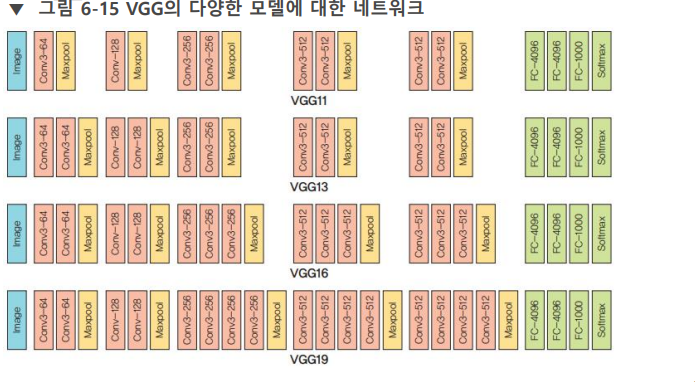

VGG 계층정의 <VGG 11 사용>

In [ ]:
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = c

    return nn.Sequential(*layers)

- get_vgg_layer() 함수를 호출하여 모델의 계층을 생성

In [ ]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True) # 데이터를 정규화 함

In [ ]:
print(vgg11_layers)

- 모델 인스턴스 생성

In [ ]:
OUTPUT_DIM = 2
model = VGG(vgg11_layers, OUTPUT_DIM)
print(model)

### 모델 학습

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

### 평가

In [ ]:
id_list, pred_list = test(model, test_images_filepaths)

vgg = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

vgg.sort_values(by='id', inplace=True)
vgg.reset_index(drop=True, inplace=True)

vgg.to_csv('/content/drive/MyDrive/SKT_FLY_AI /4주차 파이토치/vggnet.csv', index=False)

display_image_grid(test_images_filepaths)

## 사전 학습된 VGG

In [ ]:
import torchvision.models as models
pretrained_model = models.vgg11_bn(pretrained = True).cuda()
print(pretrained_model)


### 학습

In [ ]:
num_epoch = 10
pretrained_model.classifier[-1] = torch.nn.Linear(4096, 2).cuda()
optimizer = optim.Adam(pretrained_model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()
model = train_model(pretrained_model, dataloader_dict, criterion, optimizer, num_epoch)

### 평가 및 저장

In [ ]:
import pandas as pd

id_list, pred_list = test(model, test_images_filepaths)

pre_vgg = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

pre_vgg.sort_values(by='id', inplace=True)
pre_vgg.reset_index(drop=True, inplace=True)

pre_vgg.to_csv('/content/drive/MyDrive/SKT_FLY_AI /4주차 파이토치/vggnet_pretrained.csv', index=False)

display_image_grid(test_images_filepaths)

# ResNet

### ResNet

- **일반적으로**: 신경망 깊이가 깊어질수록 딥러닝 성능은 좋아질 것 같지만, 실제 성능은 그렇지 않음
- **논문**: "Deep Residual Learning for Image Recognition"에 따르면, 신경망은 깊어질수록 성능이 좋아지다가 일정한 단계를 넘어가면 성능이 나빠진다고 함
    - 이는 네트워크 깊이가 깊어지면서 무조건 성능이 좋아지지는 않는다는 것을 보여 주고 있음
- **해결책**: ResNet은 이러한 문제를 해결하기 위해 **잔차 블록(residual block)**을 도입해 잔차 연결을 추가하여 네트워크가 깊어질 수 있도록 함

### 베이직 블록 정의

In [ ]:
class BasicBlock(nn.Module):
  expansion=1

  def __init__(self, in_channels, out_channels, stride=1, downsample= False):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace = True)

    if downsample:
        conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        bn = nn.BatchNorm2d(out_channels)
        downsample = nn.Sequential(conv, bn)
    else:
      downsample =None
    self.downsample = downsample

  def forward(self,x):
    i =x
    x = self.conv1(x)
    x = self.bn1(x)
    x  = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)

    if self.dowmsample is not None:
      i = self.downsample(i)

    x+=i
    x = self.relu(x)
    return x

- 병목 블록 정의

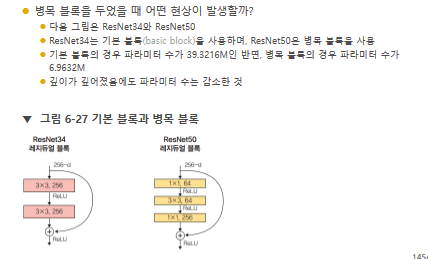

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim, zero_init_residual=False):
        super().__init__()

        block, n_blocks, channels = config
        self.in_channels = channels[0]
        assert len(n_blocks) == len(channels) == 4

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
        layers = []
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        return x

In [ ]:
from collections import namedtuple

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [ ]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

In [ ]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 8, 16, 3],
                               channels = [32,64,128, 256])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [ ]:
print(pretrained_model)

In [ ]:
OUTPUT_DIM = 2
model = ResNet(resnet101_config, OUTPUT_DIM)
print(model)

In [ ]:
#optimizer = optim.Adam(model.parameters(), lr=1e-7)
# SGD with Learning Rate Scheduling
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)